# Correlation between a neighborhood real estate price and its surrounding venues

By, Anjali Madas

In [1]:
!conda install -c conda-forge beautifulsoup4 --yes

!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes

print('Libraries installed!')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be UPDATED:

    beautifulsoup4: 4.6.0-py35h442a8c9_1 --> 4.6.3-py35_0 conda-forge

beautifulsoup4 100% |################################| Time: 0:00:00   1.61 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.17.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00   1.06 MB/s
geopy-1.17.0-p 100% |################################| Time: 0:00:00   1.64 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

print('Libraries imported!')

Libraries imported!


## I. Project Summary:  
Using data science techniques to analyze the following questions:  
- Is the surrounding venues can effect the price of real estates?  
- What kind of surrounding venues, and to what extend, can effect the price?  
- Can we use the surrounding venue to estimate the value of an accommodation over the average price of one area? And to what degree of confidence?  

The data will be:
- Average price of 2-bedrooms condos in New York city's neighborhoods. ([CityRealty](https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804))
- Venues surrounding each neighborhoods. ([FourSquare API](https://developer.foursquare.com/))  

Target audiences will be:
- Home buyers, who can roughly estimate the value of a target house over the average.  
- Planners, who can decide which venues to place around their product, so that the price is maximized.  
- Any normal person, who is wondering if that in-process building will effect his/her home's value.

## II. Prepare the data:
### 1. Scrap CityRealty website for neighborhoods average prices:  
URL: https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804

In [3]:
# Using Beautiful Soup to parse the website's html
data = requests.get('https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804').text
soup = BeautifulSoup(data, 'html.parser')

In [4]:
# Scrap the website tables for average prices
areaList = []
neighborhoodList = []

for area in soup.find_all("div", class_="tile _quote _n1 _last"):
    areaText = area.find("a").text
    areaList.append(areaText)
    
for index, table in enumerate(soup.find_all("table", class_="table table-bordered table-hover table-condensed")):
    for row in table.find_all("tr"):
        cells = row.find_all("td")
        if len(cells) > 0:
            neighborhoodName = cells[0].find("a").text.strip()
            avgPrice = cells[3].text.lstrip("$").strip()
            if "K" in avgPrice:
                avgPrice = float(avgPrice.rstrip("K")) * 1000
            else: 
                if "M" in avgPrice:
                    avgPrice = float(avgPrice.rstrip("M")) * 1000000
            
            neighborhoodList.append((
                areaList[index],
                neighborhoodName,
                avgPrice
            ))

In [5]:
# Put the scrapped data into a dataframe
nyc_neighborhoods_df = pd.DataFrame(neighborhoodList)
nyc_neighborhoods_df.columns = ['Area', 'Neighborhood', 'AvgPrice']

In [6]:
print(nyc_neighborhoods_df.shape)
nyc_neighborhoods_df.head()

(54, 3)


,Area,Neighborhood,AvgPrice
0,Brooklyn,Bedford-Stuyvesant,750000
1,Brooklyn,Boerum Hill,1.69e+06
2,Brooklyn,Brooklyn Heights,2.15e+06
3,Brooklyn,Bushwick,967000
4,Brooklyn,Carroll Gardens,1.51e+06


### 2. Get the neighborhoods coordinate:  
Free geodata is available free at: [https://geo.nyu.edu/catalog/nyu_2451_34572](https://geo.nyu.edu/catalog/nyu_2451_34572)  
A copy has been downloaded and stored in IBM cloud

In [7]:
# Download the geodata
!wget -q -O 'nyc_geo.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


In [8]:
# Load the json file
with open('nyc_geo.json') as nyc_geo_json:
    nyc_geo_data = json.load(nyc_geo_json)

In [9]:
# Get the neighborhoods list
nyc_geo_list = nyc_geo_data['features']

# Sample neighborhood node
nyc_geo_list[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

In [10]:
# Parse the json data into neighborhoods list
neighborhood_geo_list = []
for data in nyc_geo_list:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhood_geo_list.append((
        borough, neighborhood_name, neighborhood_lat, neighborhood_lon
    ))

In [11]:
# Put into a dataframe
neighborhood_geo_df = pd.DataFrame(neighborhood_geo_list)
neighborhood_geo_df.columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# Avg price data is only available for Manhattan and Brooklyn
neighborhood_geo_df = neighborhood_geo_df[(neighborhood_geo_df['Borough'] == 'Manhattan') | (neighborhood_geo_df['Borough'] == 'Brooklyn')]

neighborhood_geo_df.reset_index(drop=True, inplace=True)

In [12]:
print(neighborhood_geo_df.shape)
neighborhood_geo_df.head()

(110, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bensonhurst,40.611009,-73.995180
3,Brooklyn,Sunset Park,40.645103,-74.010316
4,Brooklyn,Greenpoint,40.730201,-73.954241


### 3. Combine the two dataframes:  
There are three problems here causing the number of neighborhoods doesn't match:  
- First, avg price data isn't available to all neighborhoods.
- Second, some neighborhoods name scrapped from the website is not same as their corresponding ones in the geo dataset.
- Third, real estate market names some neighborhoods differently, or make up of new names. All for the purpose of sale.  

Each line of price data will be considered, and suitable action will be performed:
- If the names is different, decide which one to use after searching on the internet.
- If the neighborhood is missing from the geo datafram, add it's coordinate.
- If the neighborhoods is makeup, combine them into the larger neighborhood which exist in the geo dataframe.

In [13]:
# Bedford Stuyvesant missing a '-' in the middle
neighborhood_geo_df.at[18, 'Neighborhood'] = 'Bedford-Stuyvesant'

# Downtown is Downtown Brooklyn
neighborhood_geo_df.at[41, 'Neighborhood'] = 'Downtown Brooklyn'

# Dumbo should be DUMBO
neighborhood_geo_df.at[104, 'Neighborhood'] = 'DUMBO'

# Prospect Lefferts Gardens missing a '-' in the middle
nyc_neighborhoods_df.at[15, 'Neighborhood'] = 'Prospect-Lefferts Gardens'
neighborhood_geo_df.at[43, 'Neighborhood'] = 'Prospect-Lefferts Gardens'

# South Slope - Greenwood Heights is just South Slope
nyc_neighborhoods_df.at[17, 'Neighborhood'] = 'South Slope'
# South Slope coordinates is missing
neighborhood_geo_df = neighborhood_geo_df.append({'Borough': 'Brooklyn',
                                                  'Neighborhood': 'South Slope',
                                                  'Latitude': 40.662349, 
                                                  'Longitude': -73.990350}, ignore_index=True)

# Park, Fifth Ave to 79th St is Upper East Side
nyc_neighborhoods_df.at[24, 'Neighborhood'] = 'Upper East Side'

# Flatiron/Union Square is just Flatiron
nyc_neighborhoods_df.at[29, 'Neighborhood'] = 'Flatiron District'
neighborhood_geo_df.at[99, 'Neighborhood'] = 'Flatiron District'

# Gramercy Park is just Gramercy
nyc_neighborhoods_df.at[30, 'Neighborhood'] = 'Gramercy'

# NOHO should be just NoHo
nyc_neighborhoods_df.at[33, 'Neighborhood'] = 'NoHo'
neighborhood_geo_df.at[88, 'Neighborhood'] = 'NoHo'

# NoLiTa/Little Italy is just NoLiTa
nyc_neighborhoods_df.at[34, 'Neighborhood'] = 'NoLiTa'
neighborhood_geo_df.at[76, 'Neighborhood'] = 'NoLiTa'

# SOHO should be just SoHo
nyc_neighborhoods_df.at[35, 'Neighborhood'] = 'SoHo'
neighborhood_geo_df.at[77, 'Neighborhood'] = 'SoHo'

# Stuyvesant Town / PCV is just Stuyvesant Town
nyc_neighborhoods_df.at[36, 'Neighborhood'] = 'Stuyvesant Town'

# Beekman/Sutton Place is just Sutton Place
nyc_neighborhoods_df.at[39, 'Neighborhood'] = 'Sutton Place'

# Midtown East and Midtown West will be combined into Midtown
nyc_neighborhoods_df.at[40, 'Neighborhood'] = 'Midtown'
midtown_avg = (nyc_neighborhoods_df.at[40, 'AvgPrice'] + nyc_neighborhoods_df.at[41, 'AvgPrice']) / 2
nyc_neighborhoods_df.at[40, 'AvgPrice'] = midtown_avg
nyc_neighborhoods_df.at[41, 'AvgPrice'] = '-'

# Turtle Bay/United Nations is just Turtle Bay
nyc_neighborhoods_df.at[43, 'Neighborhood'] = 'Turtle Bay'

# Central Harlem is Harlem
neighborhood_geo_df.at[60, 'Neighborhood'] = 'Harlem'

# Lincoln Center is Lincoln Square
nyc_neighborhoods_df.at[51, 'Neighborhood'] = 'Lincoln Square'

# Broadway Cooridor, Central Park West and Riverside Dr./West End Ave. will be combined to Upper West Side
nyc_neighborhoods_df.at[49, 'Neighborhood'] = 'Upper West Side'
midtown_avg = (nyc_neighborhoods_df.at[49, 'AvgPrice'] + nyc_neighborhoods_df.at[50, 'AvgPrice'] + nyc_neighborhoods_df.at[53, 'AvgPrice']) / 3
nyc_neighborhoods_df.at[49, 'AvgPrice'] = midtown_avg
nyc_neighborhoods_df.at[50, 'AvgPrice'] = '-'
nyc_neighborhoods_df.at[53, 'AvgPrice'] = '-'

# Drop the Red Hook row
nyc_neighborhoods_df.drop([16], inplace=True)

In [14]:
# Inner join the two dataframes by Neighborhoods
nyc_neighborhood_price_df = pd.concat([nyc_neighborhoods_df.set_index('Neighborhood'), neighborhood_geo_df.set_index('Neighborhood')], axis=1, join='inner')
nyc_neighborhood_price_df.drop(columns=['Area', 'Borough'], inplace=True)
nyc_neighborhood_price_df.reset_index(inplace=True)

In [15]:
# The joined dataframe
print(nyc_neighborhood_price_df.shape)
nyc_neighborhood_price_df.head()

(50, 4)


,Neighborhood,AvgPrice,Latitude,Longitude
0,Bedford-Stuyvesant,750000,40.687232,-73.941785
1,Boerum Hill,1.69e+06,40.685683,-73.983748
2,Brooklyn Heights,2.15e+06,40.695864,-73.993782
3,Bushwick,967000,40.698116,-73.925258
4,Carroll Gardens,1.51e+06,40.680540,-73.994654


### 4. Visualize the data onto a map

In [ ]:
# for choropleth map, we need another geo data which contain the Polygon type Coordinates
!wget -q -O 'nyc_geo.geojson' http://data.beta.nyc//dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson
print('Data downloaded!')

nyc_polygon_geo_data = r'nyc_geo.geojson'
latitude = 40.8021285
longitude = -73.9777254

In [1]:
# Map without markers

# create a plain world map
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map
nyc_map.choropleth(
    geo_data=nyc_polygon_geo_data,
    data=nyc_neighborhood_price_df,
    columns=['Neighborhood', 'AvgPrice'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average 2 bedrooms condo price in New York city'
)

# display map
nyc_map

NameError: name 'folium' is not defined

In [2]:
# Map with markers

# create a plain world map
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map
nyc_map.choropleth(
    geo_data=nyc_polygon_geo_data,
    data=nyc_neighborhood_price_df,
    columns=['Neighborhood', 'AvgPrice'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average 2 bedrooms condo price in New York city'
)

# add markers to map
for lat, lng, neighborhood, price in zip(nyc_neighborhood_price_df['Latitude'], nyc_neighborhood_price_df['Longitude'], nyc_neighborhood_price_df['Neighborhood'], nyc_neighborhood_price_df['AvgPrice']):
    label = '{}, ${:3.0f}'.format(neighborhood, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_map)

# display map
nyc_map

NameError: name 'folium' is not defined

### 5. Using FourSquare API to get surrounding venues:

In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
# FourSquare parameters
radius = 1000 # 1 km around the neighborhood center
limit = 200

venues = []

for lat, long, neighborhood in zip(nyc_neighborhood_price_df['Latitude'], nyc_neighborhood_price_df['Longitude'], nyc_neighborhood_price_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [21]:
# put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(4999, 7)
There are 327 unique venue types.


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueType
0,Bedford-Stuyvesant,40.687232,-73.941785,Sincerely Tommy,40.686066,-73.944294,Boutique
1,Bedford-Stuyvesant,40.687232,-73.941785,Bed-Vyne Brew,40.684751,-73.944319,Bar
2,Bedford-Stuyvesant,40.687232,-73.941785,Bed-Vyne Wine & Spirits,40.684668,-73.944363,Wine Shop
3,Bedford-Stuyvesant,40.687232,-73.941785,Anchor Coffee,40.684145,-73.941015,Coffee Shop
4,Bedford-Stuyvesant,40.687232,-73.941785,Peaches HotHouse,40.683331,-73.943853,Fried Chicken Joint


In [22]:
# one hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")

# add the neighborhood column
venues_type_onehot['Neighborhood'] = venues_df['Neighborhood']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(4999, 328)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods 

In [23]:
# get the occurrence of each venue type in each neighborhood
venue_count_df = venues_type_onehot.groupby(['Neighborhood']).sum().reset_index()

print(venue_count_df.shape)
venue_count_df.head()

(50, 328)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods 

In [24]:
# get the standardized neighborhoods' average prices
scaler = StandardScaler()
standardized_price = scaler.fit_transform(nyc_neighborhood_price_df[['AvgPrice']])

# add the normalized price to the dataframe
neighborhood_venues_withprice_df = pd.DataFrame(venue_count_df)
neighborhood_venues_withprice_df['StandardizedAvgPrice'] = standardized_price

print(neighborhood_venues_withprice_df.shape)
neighborhood_venues_withprice_df.head()

(50, 329)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods 

**This is the end of data collecting and preprocessing**  
**_neighborhood_venues_withprice_df_ will be the dataframe that will be used in the analyzing step below**

## III. Analyze the dataframe:  
### 1. Check for correlation between _occurrence of surrounding venues_ with _real estate average price_:

In [25]:
# Using LinearRegression, we can get the list of coefficient correlations between each type of venue and the average price
lreg = LinearRegression(normalize=True)

X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)

In [26]:
# let's see how well Linear Regression fit the problem
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse

print('Max positive coefs:', lreg.coef_[np.argsort(-lreg.coef_)[:10]])
print('Venue types with most postive effect:', X.columns[np.argsort(-lreg.coef_)[:10]].values)
print('Max negative coefs:', lreg.coef_[np.argsort(lreg.coef_)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(lreg.coef_)[:10]].values)
coef_abs = abs(lreg.coef_)
print('Min coefs:', lreg.coef_[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

R2-score: 0.273792308888
Mean Squared Error: 0.254179706388
Max positive coefs: [ 0.26348338  0.26213799  0.26213799  0.26213799  0.25818747  0.25818747
  0.25135936  0.24564842  0.23349638  0.22658134]
Venue types with most postive effect: ['Design Studio' 'Train Station' 'Jewish Restaurant' 'Resort' 'Buffet'
 'Cafeteria' 'Colombian Restaurant' 'Dumpling Restaurant' 'Other Nightlife'
 'Botanical Garden']
Max negative coefs: [-0.20813947 -0.20763403 -0.1798399  -0.1798399  -0.1798399  -0.17776278
 -0.17776278 -0.17776278 -0.17776278 -0.17776278]
Venue types with most negative effect: ['Board Shop' 'Gay Bar' 'Supplement Shop' 'Rest Area' 'Lighthouse' 'Office'
 'Flea Market' 'Golf Driving Range' 'Recreation Center'
 'General Entertainment']
Min coefs: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Venue types with least effect: ['TV Station' 'Gas Station' 'Pakistani Restaurant' 'Volleyball Court'
 'Hookah Bar' 'Indoor Play Area' 'Laser Tag' 'Christmas Market' 'Cemetery'
 'Mini Golf']


The result doesn't look promising:   
- The R2 score is small.  
- There are no really strong coefficient correlations.  

Looking back to our dataset, we can see that the features is much bigger than the samples.  
**PCR** (Principal Component Regression) will be used to reduce the number of features.

### 2. Applying PCR for better result:  
PCR is a regression technique which is based on PCA (Principle Component Analysis).  
It's a two steps process:  
- First, perform PCA on the features set to obtain the principle components. Then select a subset for the next step.
- Second, use regression on the previous subset of principal components to get a list of coefficient correlations. (Linear Regression will be used)

In [27]:
X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']

# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))


In [28]:
n_component_list = range(1, 51)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

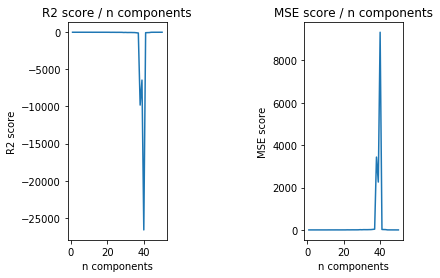

In [29]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [30]:
r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 50 R2 score: 0.454460324852
Best n: 50 MSE: 0.190944155714


In [31]:
# Use the best n_components parameter
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print("MSE:", mse)

R2 score: 0.454460324852
MSE: 0.190944155714


The result seems to improved compared to just using simple Linear Regression.

In [32]:
# Let's try to project the coefs back to the original number of features
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lreg.coef_

pcr_coefs.shape

(327,)

In [33]:
# Let's check which venue types effect the most and least
print('Max positive coefs:', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('Venue types with most positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)
print('Max negative coefs:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)
coef_abs = abs(pcr_coefs)
print('Min coefs:', pcr_coefs[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

Max positive coefs: [ 0.07212567  0.0696754   0.06052737  0.0582199   0.05228078  0.05222561
  0.04901431  0.04597368  0.04465698  0.04399769]
Venue types with most positive effect: ['Dumpling Restaurant' 'Pilates Studio' 'Design Studio' 'Pie Shop'
 'Southern / Soul Food Restaurant' 'Library' 'Sushi Restaurant' 'Resort'
 'Korean Restaurant' 'Buffet']
Max negative coefs: [-0.05116074 -0.03897274 -0.03710211 -0.03457056 -0.03452567 -0.0345195
 -0.03414522 -0.03304223 -0.03284579 -0.03284275]
Venue types with most negative effect: ['Market' 'Lingerie Store' 'Gay Bar' 'Kosher Restaurant' 'Optical Shop'
 'Food' 'Food Truck' 'Wine Bar' 'Food & Drink Shop' 'Climbing Gym']
Min coefs: [ -8.90366289e-06  -8.90366289e-06   4.09236430e-05  -4.99918920e-05
  -5.87234477e-05   1.27322576e-04   1.27322576e-04   1.27322576e-04
   1.27322576e-04   1.41722883e-04]
Venue types with least effect: ['Christmas Market' 'TV Station' 'Cemetery' 'Event Space'
 'Indoor Play Area' 'Modern European Restaurant' 'Mi

## IV. Conclusion:
Again, the result doesn't seems very promising as the R2 score is still small.
The machine learning models can't be used to predict precisely a neighborhood's average house price.  

Based on the observed coefficient correlations, fancy places like restaurants seem to boost real estate's value the most.  
In some ways, it's a logical conclusion. Neighborhoods that have many restaurants are most likely business areas such as downtown. It's where lots of people go to, lots of activities to enjoy, lots of other businesses, ....  The kind of places that people like to live at or closeby.  
And as a result of high demand, the price will be higher than other more rural neighborhoods.  